In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from ngboost import NGBRegressor
from ngboost.distns import MultivariateNormal
from sklearn.tree import DecisionTreeRegressor

from src.probabilistic_flow_boosting.independent_multivariate_boosting import IndependentNGBoost
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll, calculate_nll_ngboost

In [2]:
x_train = catalog.load("momogp_parkinsons.x_train")
y_train = catalog.load("momogp_parkinsons.y_train")

x_test = catalog.load("momogp_parkinsons.x_test")
y_test = catalog.load("momogp_parkinsons.y_test")

treeflow = catalog.load("momogp_parkinsons.model")

2022-01-19 14:42:22,907 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.x_train` (CSVDataSet)...
2022-01-19 14:42:22,917 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.y_train` (CSVDataSet)...
2022-01-19 14:42:22,919 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.x_test` (CSVDataSet)...
2022-01-19 14:42:22,923 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.y_test` (CSVDataSet)...
2022-01-19 14:42:22,925 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.model` (TFBoostDataSet)...


In [3]:
ngb = NGBRegressor(
    Dist=MultivariateNormal(y_train.shape[1]),
    Base=DecisionTreeRegressor(
        random_state=42,
        **{'max_depth': 15, 'min_samples_leaf': 32, 'max_leaf_nodes': 64}
    ),
    n_estimators=500
)

ngb_indep = IndependentNGBoost(
    params_tree = {
        'max_depth': 10, 
        'min_samples_leaf': 32, 
        'max_leaf_nodes': 32,
        'random_state': 42
    }, 
    params_ngboost = {"n_estimators": 300}
)

In [4]:
ngb.fit(x_train.values, y_train.values)

[iter 0] loss=6.1630 val_loss=0.0000 scale=0.2500 norm=2.8288
[iter 100] loss=5.8967 val_loss=0.0000 scale=0.2500 norm=2.6142
[iter 200] loss=5.7623 val_loss=0.0000 scale=0.2500 norm=2.4567
[iter 300] loss=5.6482 val_loss=0.0000 scale=0.2500 norm=2.3233
[iter 400] loss=5.5468 val_loss=0.0000 scale=0.2500 norm=2.2105


NGBRegressor(Base=DecisionTreeRegressor(max_depth=15, max_leaf_nodes=64,
                                        min_samples_leaf=32, random_state=42),
             Dist=<class 'ngboost.distns.multivariate_normal.MultivariateNormal.<locals>.MVN'>,
             random_state=RandomState(MT19937) at 0x7F5625940150)

In [5]:
ngb_indep.fit(x_train.values, y_train.values)

[iter 0] loss=3.5052 val_loss=0.0000 scale=1.0000 norm=6.9297
[iter 100] loss=3.3062 val_loss=0.0000 scale=1.0000 norm=5.7594
[iter 200] loss=3.1797 val_loss=0.0000 scale=1.0000 norm=5.1489
[iter 0] loss=3.7846 val_loss=0.0000 scale=1.0000 norm=8.6425
[iter 100] loss=3.5621 val_loss=0.0000 scale=1.0000 norm=7.3030
[iter 200] loss=3.4310 val_loss=0.0000 scale=1.0000 norm=6.5417


In [6]:
print(f"Train NLL NGB: {calculate_nll_ngboost(ngb, x_train, y_train, independent=False)}")
print(f"Test NLL NGB: {calculate_nll_ngboost(ngb, x_test, y_test, independent=False)}")

print(f"Train NLL Independent NGB: {calculate_nll_ngboost(ngb_indep, x_train, y_train, independent=True)}")
print(f"Test NLL Independent NGB: {calculate_nll_ngboost(ngb_indep, x_test, y_test, independent=True)}")

print(f"Train NLL TreeFlow: {calculate_nll(treeflow, x_train, y_train, batch_size=512)}")
print(f"Test NLL TreeFlow: {calculate_nll(treeflow, x_test, y_test, batch_size=512)}")

Train NLL NGB: 5.4441655426445665
Test NLL NGB: 5.850751857978128
Train NLL Independent NGB: 6.422337999458284
Test NLL Independent NGB: 6.861354051239283
Train NLL TreeFlow: 5.269847393035889
Test NLL TreeFlow: 5.3958563804626465


In [ ]:
for i in range(20, 50):
    print(i)
    samples_tfb = treeflow.sample(x_test.values[i:i+1, :], num_samples=1000)
    samples_ngb = np.vstack(ngb.pred_dist(x_test.values[i:i+1, :]).sample(1000))
    samples_ngb_indep = ngb_indep.scipy_distribution(x_test.values[0:1, :])[0].rvs(1000)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
    
    sns.kdeplot(x=samples_ngb_indep[:, 0], y=samples_ngb_indep[:, 1], alpha = 0.7, color = 'blue', label = 'Independent NGBoost', ax=ax[0])
    ax[0].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'black', s = 40)
    ax[0].set_title('Independent NGBoost')
    
    sns.kdeplot(x=samples_ngb[:, 0], y=samples_ngb[:, 1], alpha = 0.7, color = 'green', label = 'NGBoost', ax=ax[1])
    ax[1].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'black', s = 40)
    ax[1].set_title('NGBoost')
    
    sns.kdeplot(x=samples_tfb[0, :, 0], y=samples_tfb[0, :, 1], alpha = 0.7, color = 'orange', label = 'TreeFlow', ax=ax[2])
    ax[2].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'black', s = 40)
    ax[2].set_title('TreeFlow')

    plt.tight_layout()
    plt.show()

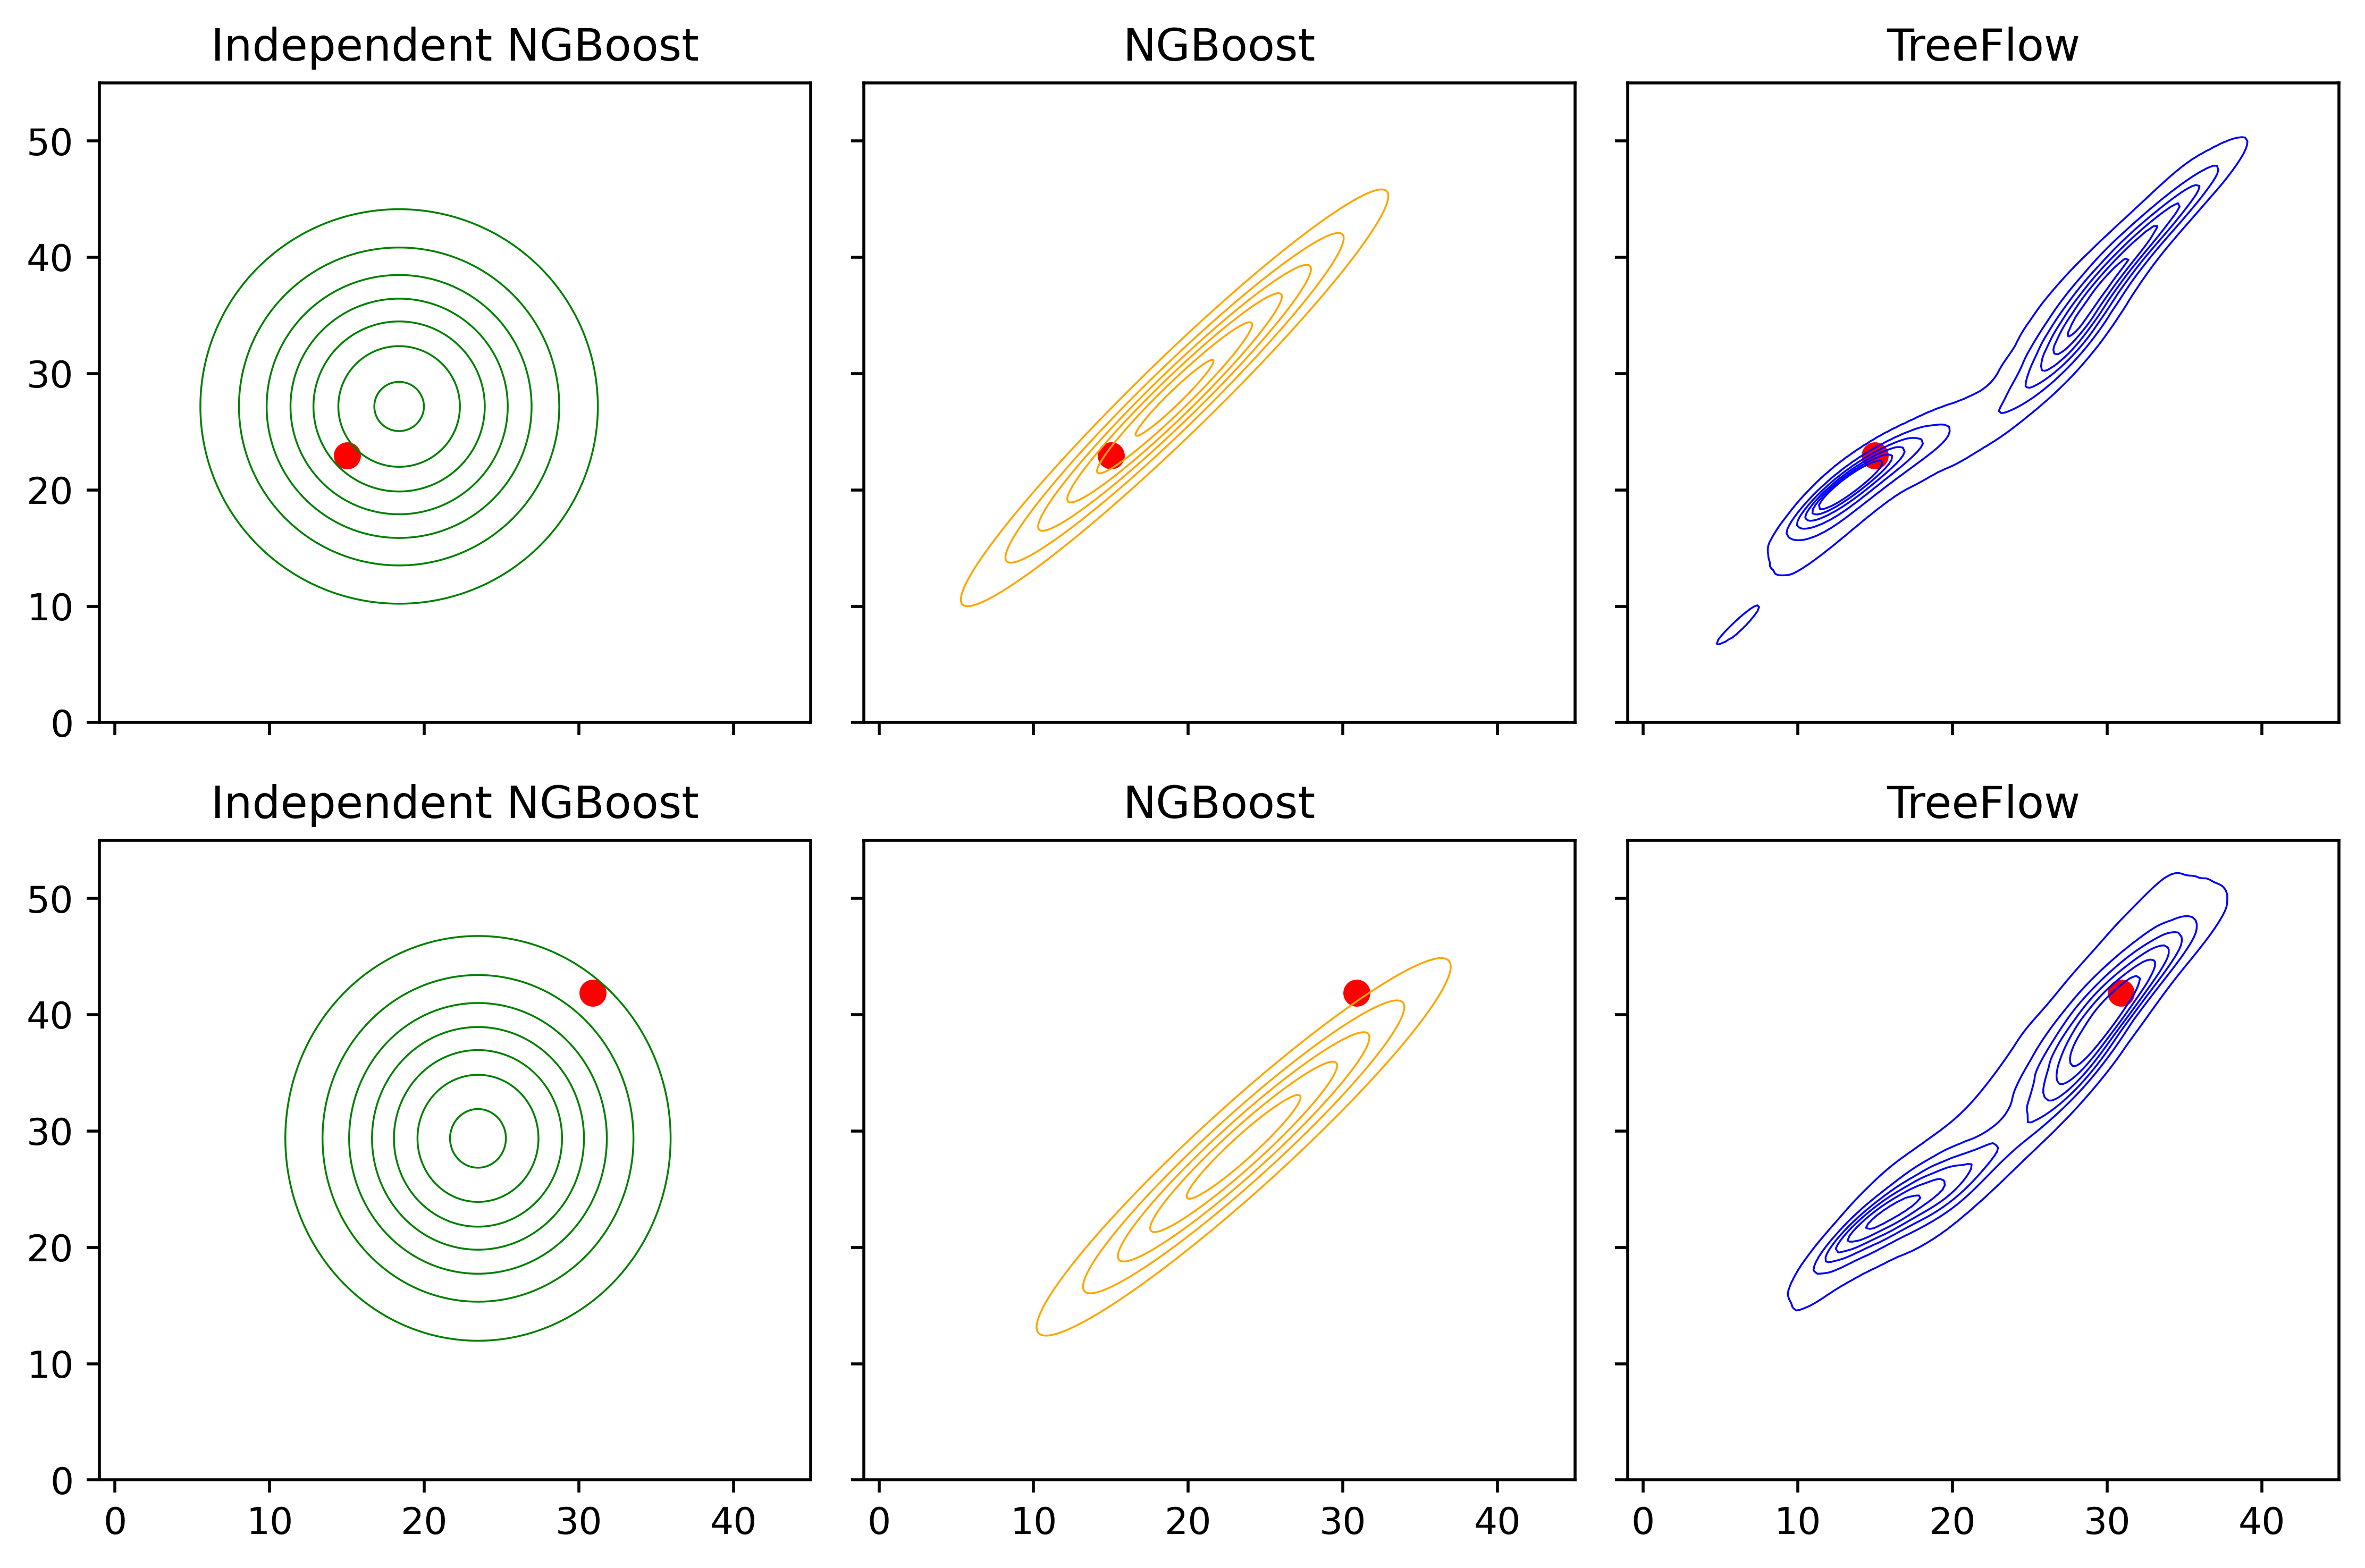

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6), sharey=True, sharex=True, dpi=500)
    
for index, i in enumerate([33, 48]):
    x, y = np.mgrid[-1:45:0.1, 0:55:0.1]
    pos = np.dstack((x, y))
    
    samples_tfb = treeflow.sample(x_test.values[i:i+1, :], num_samples=100000)
    ngb_distribution = ngb.pred_dist(x_test.values[i:i+1, :]).scipy_distribution()[0]
    ngb_indep_distribution = ngb_indep.scipy_distribution(x_test.values[i:i+1, :])[0]

    ax[index, 0].contour(x, y, ngb_indep_distribution.pdf(pos), linewidths = 0.5, levels = 7, colors = 'green')
    ax[index, 0].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red', s = 40)
    ax[index, 0].set_title('Independent NGBoost')
    
    ax[index, 1].contour(x, y, ngb_distribution.pdf(pos), linewidths = 0.5, levels = 7, colors = 'orange')
    ax[index, 1].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red', s = 40)
    ax[index, 1].set_title('NGBoost')
    
    sns.kdeplot(x=samples_tfb[0, :, 0], y=samples_tfb[0, :, 1], linewidths = 0.5, levels = 7, color = 'blue', label = 'TreeFlow', ax=ax[index, 2])
    ax[index, 2].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red', s = 40)
    ax[index, 2].set_title('TreeFlow')

plt.xlim([-1, 45])
plt.ylim([0, 55])
plt.tight_layout()
plt.savefig('parkinsons.pdf')